## Final Project Submission

* Student name: Amber Yandow 
* Student pace: full time
* Scheduled project review date/time: 14 June 2019 / 1:00pm
* Instructor name: Brandon Lewis
* Blog post URL:


# Human Activity Recognition Using Deep Neural Network


# Understanding the Business Case 
**Smart phones and watches have become ubiquitous in our society. Almost all of these devices are equipped with sensors that track our movements. Typically, a device uses a tri-axial accelerometer that measures acceleration in three spatial dimensions based on the detected orientation of the device.**

<img src="smartphone.png" width=400>

**Human activity tracking has many applications. A prominent reason for buying a smart phone and the only reason to buy the ever so popular fitbit, is to utilize the activity tracking feature for managing ones fitness. Tracker data is used in healthcare, the military, by advertising firms and corporage management.**

**Here I will use Actitracker's Wireless Sensor Data Mining(WISDM) dataset to train a Deep Neural Network that will be able to categorize six different human activities based on the raw accelerometer data**


# Understanding the data 
 **The data set that I am using is a collection of accelerometer data taken from a smartphone that 36 individuals carried in their pocket while conducting six different exercises including going upstairs/downstairs, jogging, sitting, standing and walking. For each exercise, the acceleration for the x, y, and z axis was measured at a 20Hz sampling rate which equates to 20 values per second per person. The reader also captured the timestamp and each recording was labeled with a person ID. The environment was a controlled laboratory setting**

# Data Preparation

## Importing Libraries 

In [1]:
import pandas as pd 
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy import stats

from sklearn.datasets import make_classification
import sklearn.linear_model
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.0)



## Preprocessing the data 


## Loading the data 

In [2]:
# Functions for reading/importing the data
def read_data(file_path):

    # Renaming the column heads
    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']

    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)

    # The 'z-axis' column has a ';' delimiter which must be removed
    df['z-axis'].replace(regex=True,
                         inplace=True,
                         to_replace=r';',
                         value=r'')

    # Converting 'z-axis' to float after removal of ';'
    df['z-axis'] = df['z-axis'].apply(convert_to_float)


  
    '''There is no missing data. However, without this line of code the model has trouble fitting
   and random NANs appear after attempting a transform'''

    df.dropna(axis=0, how='any', inplace=True)

    return df

'''I had trouble trying to load the data even after changing the z-axis column to a float.
This function solved the issue and was inspired by Nils Ackermann's tutorial on HAR datasets.
Resources are provided in the appendix.'''


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


df = read_data('WISDM_ar_v1.1_raw.txt')
df.head(10)

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [3]:
'''Everything looks to have loaded properly. There are a total of 6 columns with 1,098,203 
    rows each. The activity column is the only catgorical column.'''
df.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
user-id      1098203 non-null int64
activity     1098203 non-null object
timestamp    1098203 non-null int64
x-axis       1098203 non-null float64
y-axis       1098203 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


### Visualizing the data 

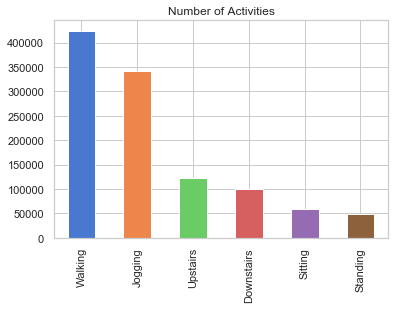

In [4]:
'''The majority of the data is classified as walking or jogging.'''
df['activity'].value_counts().plot(kind='bar',
                                   title='Number of Activities')
plt.show()

In [5]:
df['user-id'].value_counts()

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35506
21    35436
3     35161
27    34958
10    34883
18    32811
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28509
15    28154
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user-id, dtype: int64

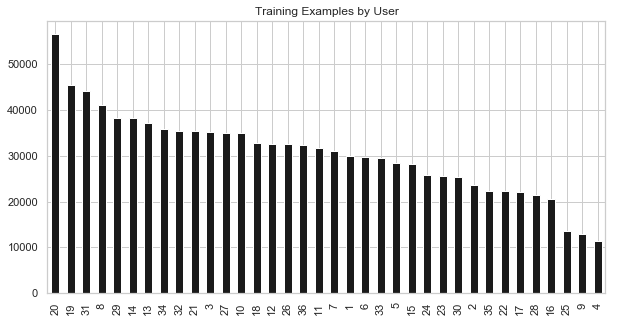

In [6]:
'''User individual value counts. User 20 having the most at 56,632 recordings and the lowest
is user 4 with 11,371. I wonder if they got paid the same...'''
df['user-id'].value_counts().plot(kind='bar', figsize=(10,5), color='k',
                                  title='Training Examples by User')
plt.show()

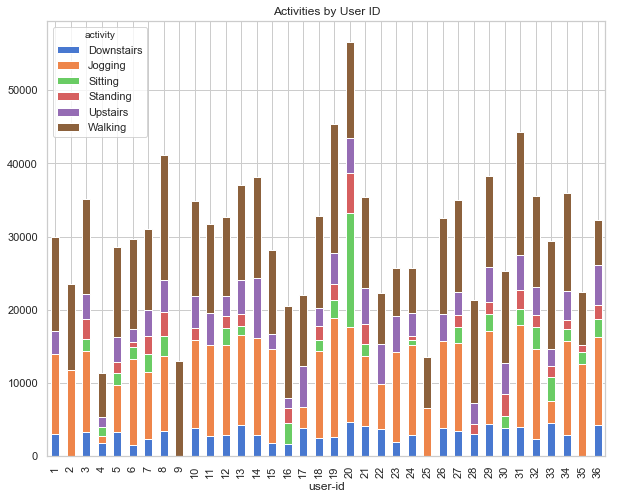

In [7]:
'''There are 12 users that did not record any sitting data. Do they have something against
sitting? Or was there a problem with the recording instrument?'''
df.groupby(['activity','user-id'])\
       .size()\
       .unstack(0)\
       .plot.bar(figsize=(10,8), stacked=True, title="Activities by User ID")

In [8]:
plt.style.use('ggplot')

'''As stated previously, the data is recorded at a sampling rate of 20Hz, 20 values per second.
Each plot only shows the first 200 records therefore each plot is a 10 second interval for each
activity.'''

def plot_activity(activity, df): #Plotting the time stamps for each activity
    activity_rows = (df['activity'] == activity)
    data = df[activity_rows]
    data = data[['x-axis', 'y-axis', 'z-axis']]
    data = data[:200] #limits the rows for plots 
    
    ax = data.plot(subplots=True, figsize=(15, 10), title=activity)

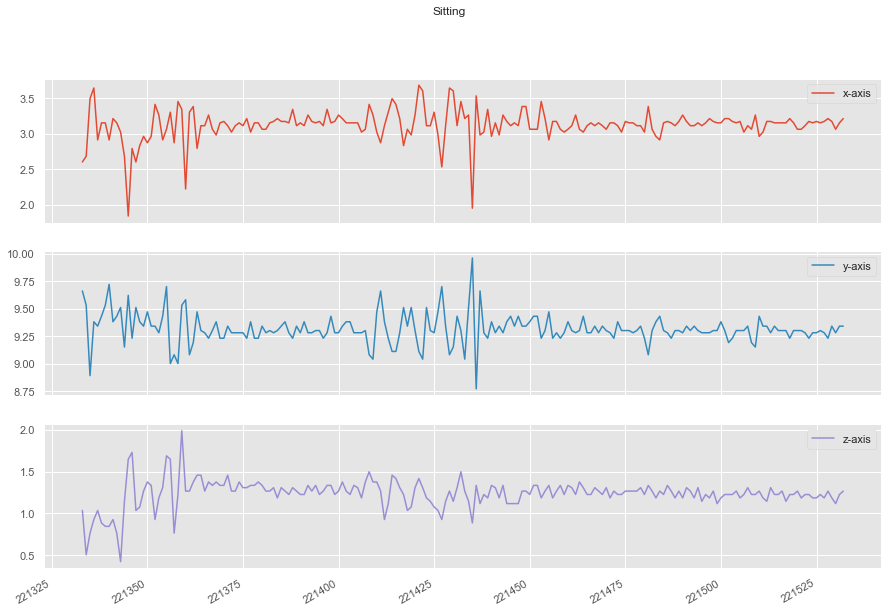

In [9]:
plot_activity("Sitting", df) 

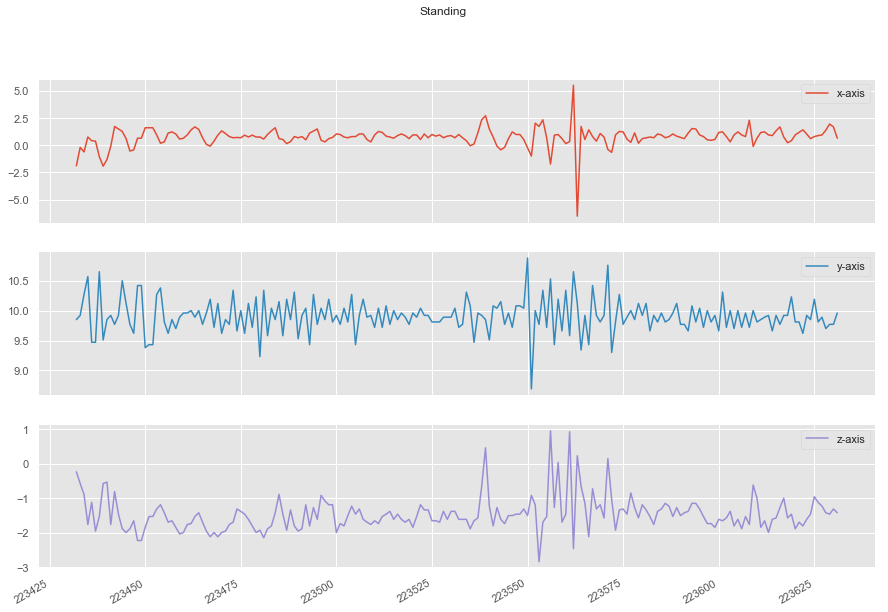

In [10]:
plot_activity("Standing", df)

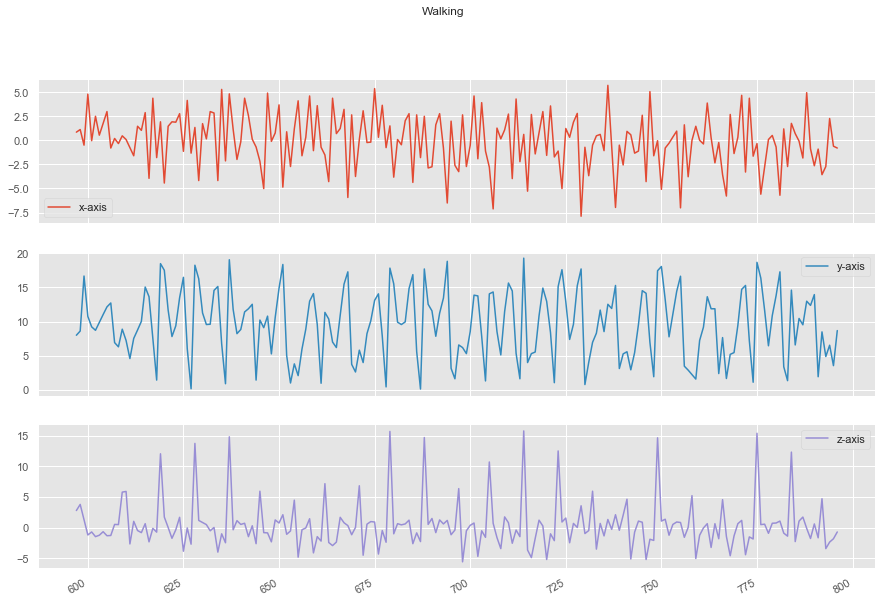

In [11]:
plot_activity("Walking", df)

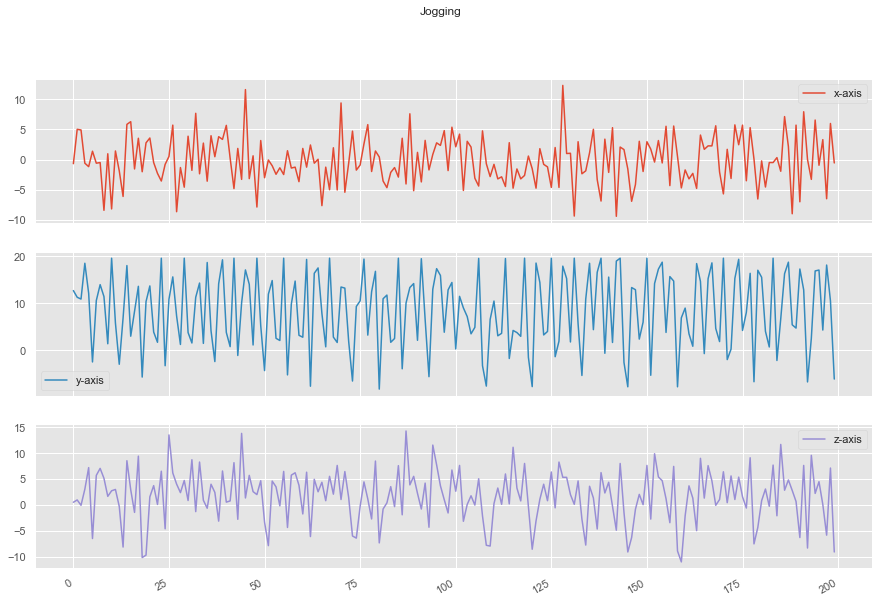

In [12]:
plot_activity("Jogging", df)

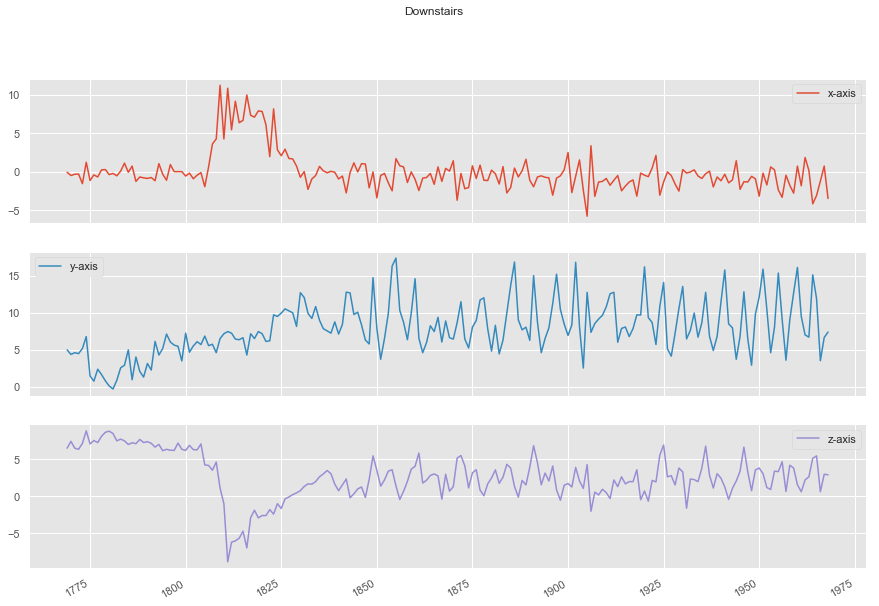

In [13]:
plot_activity("Downstairs", df)

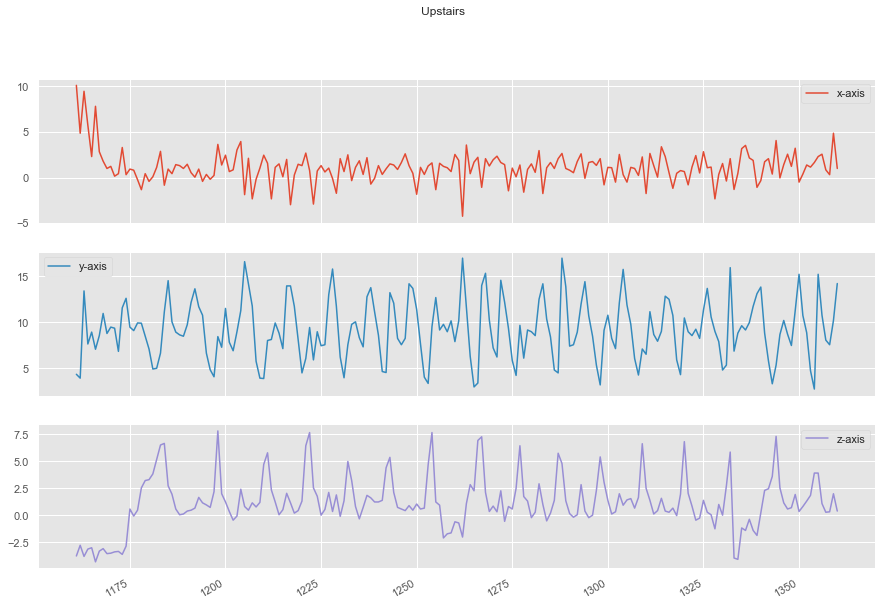

In [14]:
plot_activity("Upstairs", df)

**Jogging, walking and going upstairs have higher acceleration than sitting. Standing, sitting and going upstairs have peaks at different intervals. If the intervals are too similar our model would perform poorly.** 

## One Hot Encoding
**The deep neural network will not accept non-numerical data. So, I encoded the activity labels and create a new column for the new labels. I chose one hot over dummies because of dimensionality.**

In [15]:
# Transform the labels from String to Integer via LabelEncoder
activity_labels = LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df['activity_encoded'] = activity_labels.fit_transform(df['activity'].values.ravel())

In [ ]:
df.head()

## Train/Test Split
**I want the model to learn which activities are which from a few instances and then be able to predict the activity of an unseen instance. I split the data by user-id to avoid getting only a few instances of a users activities in either split**

In [16]:
# Splitting for test/train
df_train = df[df['user-id'] > 28]
df_test = df[df['user-id'] <= 28]

## Normalization
**I normalize the features in order to mitigate any exploding or vanishing gradients and set the values between 0-1 as is the industry standard.**

In [17]:
# Normalize features for training set
# Surpress warning
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

# Modeling 
**I used a sequential(1 layer built on top of previous layers) DNN. The network has 3 hidden layers(2 did not perform well). The first layer reshapes the data back into a matrix(we need to flatten it beforehand). The second and third layers will flatten the data again to be fed into the activation function. My backend activation function is Softmax. It forces all 6 outputs of the network to sum up to one and the value will be the probability for each of the 6 classes. My frontend activation function is the industry standard, ReLu.** 

**Constants required for time sequence data**
**- Number of time periods: This is the number of time periods within 1 record. I chose 10 second intervals so this number is 200.**
**- Number of sensors: This is 3 for the x, y, z data**
**- Number of classes: This is the amount of nodes for our output layer in the neural network. Since we want our neural network to predict the type of activity, we will take the number of classes from the encoder that we have used earlier.**

## Import libraries

In [18]:
from sklearn.model_selection import cross_val_score #3 mins
from sklearn.neural_network import MLPClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import tensorflow as tf


Using TensorFlow backend.


## Reshaping Data
**Keras DNN models expect fixed length sequences of data. Each sequence will have 200 training examples. In each example, the most common activity will be assigned to the sequence. This will greatly reduce the dimensionality.**

**Sequence data requires certain parameters.**
**- Number of time periods: This is the number of time periods within 1 record. I chose 10 second intervals so this number is 200.**
**- Number of sensors: This is 3 for the x, y, z data**
**- Number of classes: This is the amount of nodes for our output layer in the neural network. Since we want our neural network to predict the type of activity, we will take the number of classes from the encoder that we have used earlier.**

In [19]:
N_TIME_STEPS = 80 # Number of steps within 1 time segment
N_FEATURES = 3 #x, y, z
step = 40 # amount of steps from 1 segment to the next. There are 5 layers of overlap
segments = []
labels = []
for i in range(0, len(df_train) - N_TIME_STEPS, step):
    xs = df_train['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df_train['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df_train['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df_train['activity_encoded'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)
    
#reshaping
x_train = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
y_train = np.asarray(labels)

In [20]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (6584, 80, 3)
6584 training samples
y_train shape:  (6584,)


In [21]:
#This is setting our input and output dimensions 
num_time_periods, num_sensors = x_train.shape[1],x_train.shape[2] #2 mins
num_classes = activity_labels.classes_.size

In [22]:
'''If the model is to be used in an application, Keras needs to work with a software program 
that can deploy the model to an operating system. This process will not work if our data is 
multi-dimensional. This code flattens the data turning it from a 80x3 matrix into a list of
240 values.'''

x_train = x_train.reshape(x_train.shape[0], num_time_periods*num_sensors)
print('x_train shape:', x_train.shape)

x_train shape: (6584, 240)


In [23]:
x_train = x_train.astype('float32') #datatype accepted by Keras #1 min
y_train = y_train.astype('float32')

In [24]:
y_train_hot = np_utils.to_categorical(y_train, num_classes) #One hot our training y values

## Training the model 
**

In [25]:
model_dnn = Sequential() #Intialize network object #1 min
model_dnn.add(Reshape((N_TIME_STEPS, 3), input_shape=(num_time_periods*num_sensors,)))
model_dnn.add(Dense(100, activation='relu')) #layers 1,2,3
model_dnn.add(Dense(100, activation='relu')) #ReLu activation is 0 when z < 0
model_dnn.add(Dense(100, activation='relu'))
model_dnn.add(Flatten())
model_dnn.add(Dense(num_classes, activation='softmax'))
model_dnn.compile(loss=keras.losses.categorical_crossentropy, #measuring loss
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

## Fit the DNN Model in Keras
**Here I train the model with the training data and define a early stopping callback montior for training accuracy(If training does not improve after 2 epochs then it will stop). 80:20 split for training and validation.

In [26]:
BATCH_SIZE = 400 #2 mins
EPOCHS = 100
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]
history = model_dnn.fit(x_train, y_train_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=callbacks_list,validation_split=0.2,verbose=1)

Train on 5267 samples, validate on 1317 samples
Epoch 1/100
5267/5267 [==============================] - 2s 365us/step - loss: 1.7715 - acc: 0.2774 - val_loss: 1.7323 - val_acc: 0.3424
Epoch 2/100
5267/5267 [==============================] - 2s 378us/step - loss: 1.6566 - acc: 0.3843 - val_loss: 1.6554 - val_acc: 0.3212
Epoch 3/100
5267/5267 [==============================] - 2s 375us/step - loss: 1.5533 - acc: 0.3759 - val_loss: 1.6120 - val_acc: 0.3227


## Learning Curve

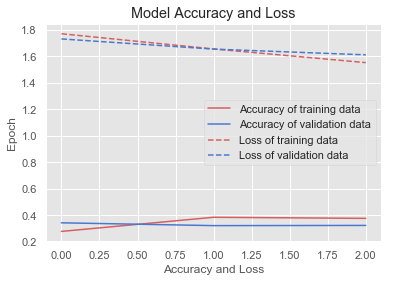

In [27]:
plt.figure()
plt.plot(history.history['acc'],'r',label='Accuracy of training data')
plt.plot(history.history['val_acc'],'b',label='Accuracy of validation data')
plt.plot(history.history['loss'],'r--',label='Loss of training data')
plt.plot(history.history['val_loss'],'b--',label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.xlabel('Accuracy and Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()

In [28]:
#Normisation of test data
pd.options.mode.chained_assignment = None  # default='warn'
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [29]:
N_TIME_STEPS = 80
N_FEATURES = 3
step = 40
segments = []
labels = []
for i in range(0, len(df_test) - N_TIME_STEPS, step):
    xs = df_test['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df_test['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df_test['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df_test['activity_encoded'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)
    
#reshaping
x_test = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
y_test = np.asarray(labels)

num_time_periods, num_sensors = x_test.shape[1],x_test.shape[2]
num_classes = activity_labels.classes_.size

x_test = x_test.reshape(x_test.shape[0], num_time_periods*num_sensors)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test_hot = np_utils.to_categorical(y_test, num_classes)

In [30]:
score = model_dnn.evaluate(x_test,y_test_hot,verbose=1) # 9mins

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])


ValueError: Error when checking input: expected reshape_1_input to have shape (240,) but got array with shape (600,)

In [ ]:
from sklearn.metrics import confusion_matrix

LABELS = ['Downstairs','Jogging','Sitting','Standing','Upstairs', 'Walking']

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_dnn.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)




In [ ]:
print(classification_report(max_y_test, max_y_pred_test))

# Appendix